## A Multiconstrained optimisation problem, finding the best fantasy football team

**The data**: Is downloaded from [official fantasy premier league](www.fantasy.premierleague.com) website.

This was inspired by this [medium](https://medium.com/@kangeugine/fantasy-football-as-a-data-scientist-part-2-knapsack-problem-6b7083955e93) post.

Selecting 'x' number players with £100 limit can also be looked as a knapsack problem ([wiki](https://en.wikipedia.org/wiki/Knapsack_problem)), a classic optimization problem. Given a set of items, each with a weight and a value, determine the number of each item to include in a collection so that the total weight is less than or equal to a given limit and the total value is as large as possible. 

Our problem though is slightly different, we have additional constraints to the classic knapsack problem. As the matter of the fact we also need to satisfy the following requirements:

 - "Total 15 Players"
 - "Only 2 GK"
 - "Less than 4 DEF"
 - "Less than 5 MID"
 - "Less than 3 STR"


This becomes a multidimensional knapsack problem, and the traditional tools fall short. We can define the problem as a multiconstrained optimization binary problem and solve it with the package 'pulp'. Here is how.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Get the data

In [3]:
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
JSONContent = requests.get(url).json()

In [4]:
players = pd.DataFrame(JSONContent['elements'])
events = pd.DataFrame(JSONContent['events'])
phases = pd.DataFrame(JSONContent['phases'])
teams = pd.DataFrame(JSONContent['teams'])
total_players = JSONContent['total_players']
game_settings = JSONContent['game_settings']

## Preprocess the data for the optimisation problem

In [6]:
data = players[['first_name', 'second_name','element_type', 'now_cost', 'total_points']]
data['total_points'] = data['total_points'].astype(int)
data['now_cost'] = data['now_cost'].astype(int)

data = data.rename(columns={'now_cost':'cost', 'element_type':'position'})
positions_dict = {1: "GK", 2: "DEF", 3: "MID", 4:"STR"}
data.replace({"position": positions_dict}, inplace=True)
data.sample(10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,first_name,second_name,position,cost,total_points
338,David,McGoldrick,STR,55,0
418,Etienne,Capoue,MID,50,79
175,Theo,Walcott,MID,65,101
283,DeAndre,Yedlin,DEF,45,63
244,Riyad,Mahrez,MID,85,102
236,Danilo Luiz,da Silva,DEF,50,46
313,Emiliano,Buendía,MID,60,0
123,Andreas,Christensen,DEF,50,22
303,Ben,Godfrey,DEF,45,0
149,Martin,Kelly,DEF,40,26


## EDA

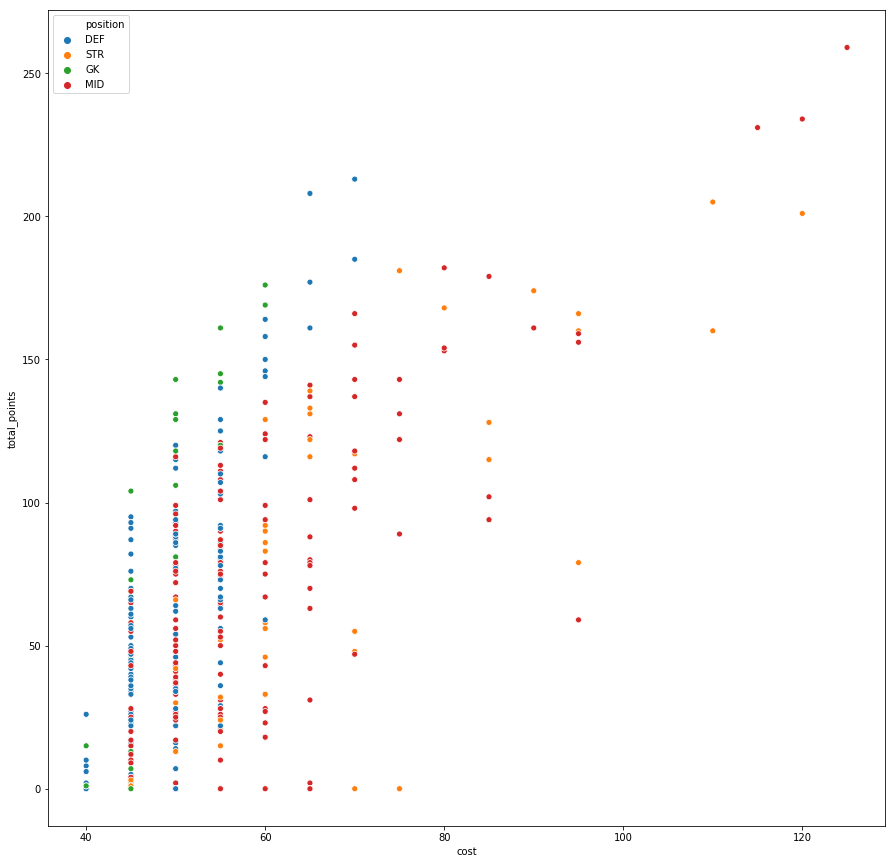

In [9]:
ax = sns.scatterplot(x="cost", y="total_points", hue="position", data=data)

## SOLVE OPTIMISATION PROBLEM

In [10]:
from pulp import *

player = [str(i) for i in range(data.shape[0])]
point = {str(i): data['total_points'][i] for i in range(data.shape[0])} 
cost = {str(i): data['cost'][i] for i in range(data.shape[0])}
gk = {str(i): 1 if data['position'][i] == 'GK' else 0 for i in range(data.shape[0])}
defe = {str(i): 1 if data['position'][i] == 'DEF' else 0 for i in range(data.shape[0])}
mid = {str(i): 1 if data['position'][i] == 'MID' else 0 for i in range(data.shape[0])}
stri = {str(i): 1 if data['position'][i] == 'STR' else 0 for i in range(data.shape[0])}
xi = {str(i): 1 for i in range(data.shape[0])}

prob = LpProblem("Fantasy Football",LpMaximize)
player_vars = LpVariable.dicts("Players",player,0,1,LpBinary)

# objective function
prob += lpSum([point[i]*player_vars[i] for i in player]), "Total Cost"

# constraint
prob += lpSum([player_vars[i] for i in player]) <= 15, "Total 15 Players"
prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 1_000.0, "Total Cost"
prob += lpSum([gk[i] * player_vars[i] for i in player]) <= 2, "Only 2 GK"
prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 5, "Less than 4 DEF"
prob += lpSum([mid[i] * player_vars[i] for i in player]) <= 5, "Less than 5 MID"
prob += lpSum([stri[i] * player_vars[i] for i in player]) <= 3, "Less than 3 STR"

# solve
status = prob.solve()
print("Problem solution is {}".format(LpStatus[status]))
if LpStatus[status] == 'Optimal':
    print("Score obtained is {:.2f}".format(value(prob.objective)))

Problem solution is Optimal
Score obtained is 2554.00


In [11]:
selected_players = []
for v in prob.variables():
    if v.varValue == 1.0:
#         print(v.name, "=", v.varValue)
        index = v.name.split("_")[1]
        selected_players.append(int(index))
        
print("SELECTED PLAYER LIST:")
data.iloc[selected_players, :]

SELECTED PLAYER LIST:


,first_name,second_name,position,cost,total_points
121,David,Luiz Moreira Marinho,DEF,60,164
155,Luka,Milivojevic,MID,70,166
156,Andros,Townsend,MID,60,135
170,Jordan,Pickford,GK,55,161
173,Gylfi,Sigurdsson,MID,80,182
208,Andrew,Robertson,DEF,70,213
209,Trent,Alexander-Arnold,DEF,70,185
210,Virgil,van Dijk,DEF,65,208
216,Alisson,Ramses Becker,GK,60,176
230,Aymeric,Laporte,DEF,65,177


In [12]:
team_cost = data.iloc[selected_players,3].sum()
print(f"The total cost of the team is {team_cost} £")

The total cost of the team is 1000 £


## Explore solution

Let's look at where the team sit in the scatter plot

In [13]:
selected = np.zeros(len(data))
selected[selected_players] = 1.0
data['selected'] = selected

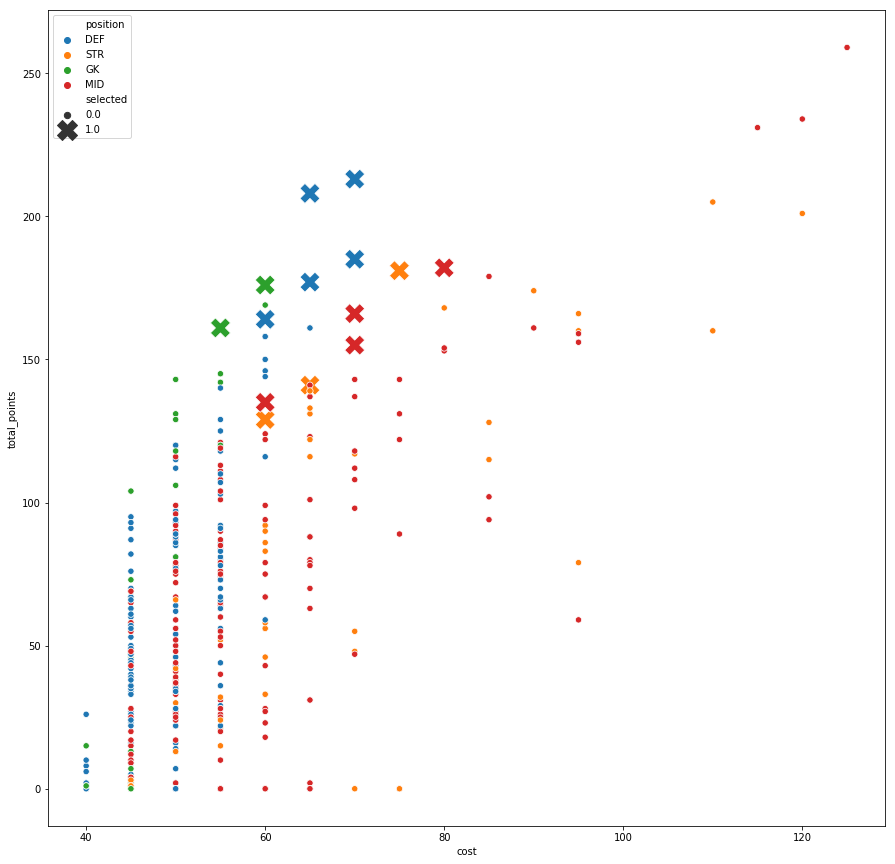

In [14]:
ax = sns.scatterplot(x="cost", y="total_points", hue="position", size='selected',sizes=(400, 40), style='selected', data=data)

## A greedy algorithm approach

In [15]:
greedy_df = data.sort_values(by='total_points', ascending=False).head(16)

In [17]:
greedy_df['cost'].sum()

1385

In [18]:
greedy_df

,first_name,second_name,position,cost,total_points,selected
218,Mohamed,Salah,MID,125,259,0.0
241,Raheem,Sterling,MID,120,234,0.0
219,Sadio,Mané,MID,115,231,0.0
208,Andrew,Robertson,DEF,70,213,1.0
210,Virgil,van Dijk,DEF,65,208,1.0
10,Pierre-Emerick,Aubameyang,STR,110,205,0.0
237,Sergio,Agüero,STR,120,201,0.0
209,Trent,Alexander-Arnold,DEF,70,185,1.0
173,Gylfi,Sigurdsson,MID,80,182,1.0
64,Ryan,Fraser,MID,75,181,1.0
